# **Intro**
In this notebook I set up semi-supervised VAE that disentangles the rotation and digits of MNIST numbers. 
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: rotation, digit, and everything else (slack).
To enforce this disentanglement, there are classification losses on the rotation and digit embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.
The model is depicted below.

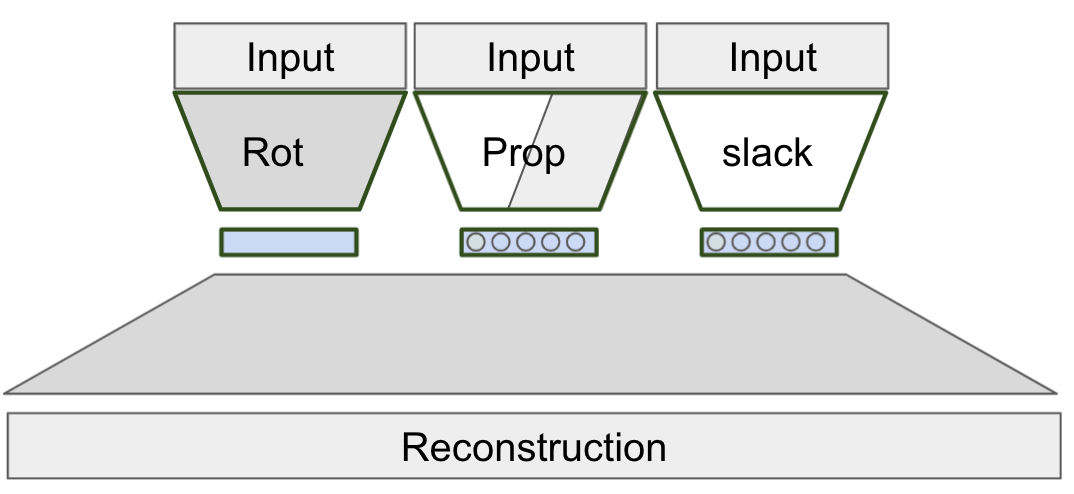


The experimental set-up is as follows:
The numbers are rotated 0, 15, 30, 45, 60, and 75 degrees. 
The model differentiates domains (rotations, referred to as *labels* in the code) from predicted values (digits, , referred to as *Y* in the code). 
The idea is to be able to provide correct labels in a new domain. 
The semi-supervision section has a new domain (30 degrees) without a Y (no digit).


This is analogous to the following situation: 
single-cell profiles where a patient or sequencing method is the domain (noise we would like to remove) and cell type (the label) is what we would like to predict.
This is done in a semi-supervised fashion because we would like to use bulk data in addition to single-cell.
However, bulk data is assumed to be a sum over many cell-types (i.e. we don't know the labels).
There is one simplification in this approach -- we predict a single-cell type for now.
Realistically, we predict a continuous vector of cell-type proportions.
Currently, we predict a 1-hot representation of cell-type identity.

Using both of these sources of data we hope that we can work on OOD stuff.
We focus on interpolation, not extrapolation, but this is not directly done in this notebook.

This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae


# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [51]:
import os, sys
RUN_COLAB = False

if RUN_COLAB:
    NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
    sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')

In [52]:
# prelude: set up git, etc.
if RUN_COLAB:
    %cd {NB_ROOT_PATH}
    !( source setup.sh )

In [53]:
if RUN_COLAB:
    %%bash
    # do your git operations here

    #git status

# **Imports**

In [54]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# programming stuff
import time
import os
import pickle
from pathlib import Path

# I disable eager execution ... forgot why
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

if RUN_COLAB:
    # Load the TensorBoard notebook extension
    %load_ext tensorboard

    # load methods from other files
    from mnist_preprocessing import generate_data as gd



    warnings.filterwarnings('ignore')
    %pylab inline

In [55]:
if RUN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# **Load / Pre-process data**
Import pre-processed pseudobulks

In [56]:
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_pbmc_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/diva_pbmc/"
num_genes = 1000


def read_files(data_path, file_idx, file_name):
  pbmc_rep1_pseudobulk_file = os.path.join(data_path, f"{file_name}_pseudo_{file_idx}.pkl")
  pbmc_rep1_prop_file = os.path.join(data_path, f"{file_name}_prop_{file_idx}.pkl")
  pbmc_rep1_gene_file = os.path.join(data_path, f"{file_name}_genes.pkl")

  pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
  prop_path = Path(pbmc_rep1_prop_file)
  gene_path = Path(pbmc_rep1_gene_file)

  prop_df = pickle.load( open( prop_path, "rb" ) )
  pseudobulks_df = pickle.load( open( pseudobulk_path, "rb" ) )
  gene_df = pickle.load( open( gene_path, "rb" ) )

  return (pseudobulks_df, prop_df, gene_df)

def read_all_files(data_path, idx_range, file_name):

  X_concat = None

  for idx in idx_range:
    X_train, Y_train, gene_df = read_files(data_path, idx, file_name)
    X_train.columns = gene_df["gene_ids"]

    if X_concat is None:
      X_concat, Y_concat = X_train, Y_train
    else:
      X_concat = pd.concat([X_concat, X_train])
      Y_concat = pd.concat([Y_concat, Y_train])

  return (X_concat, Y_concat, gene_df)



# get all the augmented data
X_train, Y_train, gene_df = read_all_files(aug_data_path, range(0, 12), "pbmc_rep1_10xV2a_sm2_cells")

#X_train, Y_train, gene_df = read_files(aug_data_path, 0, "pbmc_rep1_10xV2a_sm2_cells")
#X_train_1, Y_train_1, _ = read_files(aug_data_path, 1, "pbmc_rep1_10xV2a_sm2_cells")
#X_train_2, Y_train_2, _ = read_files(aug_data_path, 2, "pbmc_rep1_10xV2a_sm2_cells")
#X_train_3, Y_train_3, _ = read_files(aug_data_path, 3, "pbmc_rep1_10xV2a_sm2_cells")
#X_train_4, Y_train_4, _ = read_files(aug_data_path, 4, "pbmc_rep1_10xV2a_sm2_cells")
#X_train_5, Y_train_5, _ = read_files(aug_data_path, 5, "pbmc_rep1_10xV2a_sm2_cells")
#X_train_6, Y_train_6, _ = read_files(aug_data_path, 6, "pbmc_rep1_10xV2a_sm2_cells")
#X_train_7, Y_train_7, _ = read_files(aug_data_path, 7, "pbmc_rep1_10xV2a_sm2_cells")
#X_train_8, Y_train_8, _ = read_files(aug_data_path, 8, "pbmc_rep1_10xV2a_sm2_cells")
#X_train_9, Y_train_9, _ = read_files(aug_data_path, 9, "pbmc_rep1_10xV2a_sm2_cells")
#X_train_10, Y_train_10, _ = read_files(aug_data_path, 10, "pbmc_rep1_10xV2a_sm2_cells")
#X_train_11, Y_train_11, _ = read_files(aug_data_path, 11, "pbmc_rep1_10xV2a_sm2_cells")

### need to filter to genes found in smartseq2
_, _, gene_df_sm2 = read_files(aug_data_path, 0, "pbmc_rep1_sm2")
genes_common = np.intersect1d(gene_df_sm2["gene_ids"], gene_df["gene_ids"])


X_train = X_train[genes_common]
gene_df = pd.DataFrame([X_train.columns.values])
gene_df = gene_df.transpose()
gene_df.columns = ["gene_ids"]

print(Y_train.shape)
print(X_train.shape)
print(gene_df.shape)

#n_tot_samples = 12
#n_cell_types = 9

n_tot_samples = 12
n_cell_types = 6
train_file_name = "pbmc_rep1_10xV2a_sm2_cells"
n_train = 1000

(12000, 6)
(12000, 18499)
(18499, 1)


In [57]:
np.sum(Y_train, axis=1)

0    1.0
0    1.0
0    1.0
0    1.0
0    1.0
    ... 
0    1.0
0    1.0
0    1.0
0    1.0
0    1.0
Length: 12000, dtype: float64

In [58]:
gene_df

,gene_ids
0,ENSG00000000003_TSPAN6
1,ENSG00000000419_DPM1
2,ENSG00000000457_SCYL3
3,ENSG00000000460_C1orf112
4,ENSG00000000938_FGR
...,...
18494,ENSG00000283033_RP11-219A15.5
18495,ENSG00000283064_RP1-221C16.8
18496,ENSG00000283103_LLNLR-245B6.1
18497,ENSG00000283117_CTD-2060L22.1


# **Experimental Setup**

Now lets set up our experiments

In [59]:
##################################################
#####. Design the experiment
##################################################

## 3 is unlabeled
## we test on 0

#X_full = np.concatenate([X_train, X_train_1, X_train_2, X_train_3, X_train_4, X_train_5,
#                         X_train_6, X_train_7, X_train_8, X_train_9, X_train_10, X_train_11])
#Y_full = np.concatenate([Y_train, Y_train_1, Y_train_2, Y_train_3, Y_train_4, Y_train_5,
#                         Y_train_6, Y_train_7, Y_train_8, Y_train_9, Y_train_10, Y_train_11])
X_full = X_train.to_numpy()
Y_full = Y_train.to_numpy()



## get the top variable genes
X_colmean = X_full.mean(axis=0)
X_colvar = X_full.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
X_full = X_full[:,idx_top]
gene_df = gene_df.iloc[idx_top]

## normalize within sample
X_full = scale(X_full, axis=1)
               
print(X_full.shape)

### also create the condition label 
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                              np.full(n_train, 2), np.full(n_train, 3),
                              np.full(n_train, 4), np.full(n_train, 5),
                              np.full(n_train, 6), np.full(n_train, 7),
                              np.full(n_train, 8), np.full(n_train, 9),
                              np.full(n_train, 10), np.full(n_train, 11)], axis=0)
label_full = to_categorical(Label_full)

# indexes for the training, 3 and 0
idx_train = np.where(np.logical_and(Label_full!=2, Label_full!=0))[0]
idx_3 = np.where(Label_full==2)[0]
idx_0 = np.where(Label_full==0)[0]


# for unknown proportions; i.e. 3 
X_unkp = X_full[idx_3,]
label_unkp = label_full[idx_3,]
y_unkp = Y_full[idx_3,]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
y_kp = Y_full[idx_train,]


# test; i.e. 75 degrees
X_0 = X_full[idx_0,]
label_0 = label_full[idx_0,]
y_0 = Y_full[idx_0,]




/tmp/ipykernel_7390/3648581818.py:20: RuntimeWarning: invalid value encountered in true_divide
  X_CoV = np.array(np.divide(X_colvar, X_colmean))


(12000, 1000)


In [60]:
np.min(X_train.mean(axis=1))
np.max(X_train.mean(axis=1))
np.median(X_train.mean(axis=1))

40.36510323635076

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.007s...
[t-SNE] Computed neighbors for 12000 samples in 3.965s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 1.179789
[t-SNE] KL divergenc

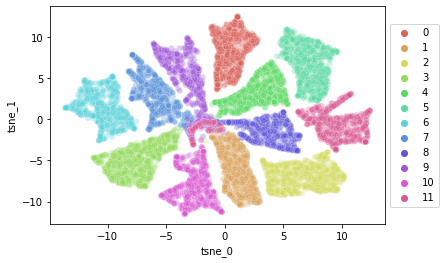

In [61]:
## plot samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_full)

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['augmentation'] = Label_full

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="augmentation",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# **Model Definition**


## Hyperparameters

In [62]:
batch_size = 500
n_epoch = 100

alpha_rot = 1000000
alpha_prop = 100 

beta_kl_slack = 10
beta_kl_rot = 100
beta_kl_prop = 10


n_x = X_full.shape[1]
n_y = Y_full.shape[1]
n_label = n_tot_samples  # 6 "patients" 1 sample augmented into 6 distinct versions
n_label_z = 64  # 64 dimensional representation of rotation


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = Y_full.shape[1] # latent space size, one latent dimension PER cell type
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of encoder hidden layer
decoder_out_dim = n_x # dim of decoder output layer

activ = 'relu'
optim = Adam(learning_rate=0.001)

print(f"length of X {n_x} and length of y {n_y} and n_label {n_label}")



length of X 1000 and length of y 6 and n_label 12


## Encoder

In [63]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))

# concatenate input with the label 
inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_s = Dense(encoder_dim, activation=activ, name="encoder_slack")(inputs)
encoder_p = Dense(encoder_dim, activation=activ, name="encoder_prop")(inputs)
encoder_r = Dense(encoder_dim, activation=activ, name="encoder_rot")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_z, activation='linear', name = "mu_slack")(encoder_s)
l_sigma_slack = Dense(n_z, activation='linear', name = "sigma_slack")(encoder_s)

mu_prop = Dense(n_label_z, activation='linear', name = "mu_prop")(encoder_p)
l_sigma_prop = Dense(n_label_z, activation='linear', name = "sigma_prop")(encoder_p)

mu_rot = Dense(n_label_z, activation='linear', name = "mu_rot")(encoder_r)
l_sigma_rot = Dense(n_label_z, activation='linear', name = "sigma_rot")(encoder_r)


## Latent Space

In [64]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_z])
z_prop = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_prop")([mu_prop, l_sigma_prop, n_label_z])
z_rot = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label_z])

z_concat = concat([z_slack, z_prop, z_rot])

## Decoder + Classifiers

In [65]:
def null_f(args):
    return args

###### DECODER
# set up decoder network
# this is a decoder with 512 hidden layer
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

d_in = Input(shape=(n_z+n_label_z+n_label_z,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)

# set up the decoder part that links to the encoder
h_p = decoder_hidden(z_concat)
outputs = decoder_out(h_p)

###### Proportions classifier
# this is the proportions we try to estimate
prop_h1 = Dense(20, activation='linear', name = "prop_h1")
prop_h2 = Dense(n_z, activation='linear', name = "prop_h2")
prop_softmax = Softmax(name = "mu_prop_pred")
decoder_sigma = Lambda(null_f, name = "l_sigma_prop_pred")

prop_1_out = prop_h1(z_prop)
prop_2_out = prop_h2(prop_1_out)
prop_outputs = prop_softmax(prop_2_out)
sigma_outputs_p = decoder_sigma(l_sigma_rot)



###### Rotations classifier
# this is the rotation we try to estimate
rot_h1 = ReLU(name = "rot_h1")
rot_h2 = Dense(n_label, activation='linear', name = "rot_h2")
rot_softmax = Softmax(name = "mu_rot_pred")
decoder_sigma_r = Lambda(null_f, name = "l_sigma_rot_pred")


rot_1_out = rot_h1(z_rot)
rot_2_out = rot_h2(rot_1_out)
rotation_outputs = rot_softmax(rot_2_out)
sigma_outputs_r = decoder_sigma_r(l_sigma_rot)








## Loss

In [66]:

def vae_loss(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_prop = beta_kl_prop * K.sum(K.exp(l_sigma_prop) + K.square(mu_prop) - 1. - l_sigma_prop, axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_prop + kl_rot + kl_slack

def KL_loss(y_true, y_pred):
	return(beta_kl * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(mean_squared_error(y_true, y_pred), axis=-1)


def prop_loss(y_true, y_pred):
  #return KLDivergence(y_true, y_pred) * alpha_prop
	return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_prop


def prop_loss_unknown(y_true, y_pred):
  #return KLDivergence(prop_outputs, y_pred) * alpha_prop
  return K.sum(mean_absolute_error(prop_outputs, y_pred), axis=-1) * alpha_prop


def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)*alpha_rot
    return recon



## Make the computational graph

In [67]:

known_prop_vae = Model(X, [outputs, prop_outputs, rotation_outputs, sigma_outputs_p])
unknown_prop_vae = Model(X, [outputs, prop_outputs, rotation_outputs])

known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss, None]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss_unknown, class_loss]) #, metrics = [KL_loss, recon_loss])


encoder = Model(X, [z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot])

decoder = Model(d_in, d_out)

print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Exception ignored in: <function tqdm.__del__ at 0x7f07ba7505e0>
Traceback (most recent call last):
  File "/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7f07ba7505e0>
Traceback (most recent call last):
  File "/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
encoder_slack (Dense)           (None, 512)          512512      input_5[0][0]                    
__________________________________________________________________________________________________
encoder_prop (Dense)            (None, 512)          512512      input_5[0][0]                    
__________________________________________________________________________________________________
encoder_rot (Dense)             (None, 512)          512512      input_5[0][0]                    
____________________________________________________________________________________________

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [68]:


def fit_model(X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop, epochs):
    assert len(X_known_prop) % len(X_unknown_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    
    for epoch in range(epochs):
        labeled_index = np.arange(len(X_known_prop))
        np.random.shuffle(labeled_index)

        # Repeat the unlabeled data to match length of labeled data
        unlabeled_index = []
        for i in range(len(X_known_prop) // len(X_unknown_prop)):
            l = np.arange(len(X_unknown_prop))
            np.random.shuffle(l)
            unlabeled_index.append(l)
        unlabeled_index = np.concatenate(unlabeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        for i in range(batches):
            # Labeled
            index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
            loss = known_prop_vae.train_on_batch(X_known_prop[index_range], 
                                                    [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range]])
            
            # Unlabeled
            y_shuffle = np.identity(10, dtype=np.float32)
            for idx in range(0, 49):
                y_shuffle = np.vstack((y_shuffle, np.identity(10, dtype=np.float32)))
            #np.random.shuffle(y_shuffle)
            y_shuffle = np.zeros((batch_size, 10))
            y_shuffle[:,0] = 1
            index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
            loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range], 
                                                        [X_unknown_prop[index_range], y_shuffle, label_unknown_prop[index_range]])]


            history.append(loss)
            
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

Now train

In [69]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)


In [70]:
# X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop
history = fit_model(X_unkp,
                    label_unkp,
                    X_kp, 
                    y_kp,
                    label_kp, epochs=n_epoch)

print(X_0[0].shape) 
print(y_0[0].shape)


z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_0, batch_size=batch_size)
test_error = [mean_abs_error(prop_outputs[idx], y_0[idx]) 
                  for idx in range(0, X_0.shape[1])]

print(f"mean test_error: {np.round(np.mean(test_error), decimals=3)}\n"
      f"median test_error: {np.round(np.median(test_error), decimals=3)}\n"
      f"max test_error: {np.round(np.max(test_error), decimals=3)}")




Elapsed:  13.024077892303467
(1000,)
(6,)
mean test_error: 0.038
median test_error: 0.037
max test_error: 0.083


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [71]:
idx = 2
print(f"abs diff. {abs(prop_outputs[idx] - y_0[idx])}")
print(f"y_est {prop_outputs[idx]}")
print(f"y_true {y_0[idx]}")
sum(prop_outputs[idx])

abs diff. [0.07255529290437698 0.01519435620307924 0.04879800879955292
 0.013310726404190065 0.0011349205970764276 0.02300853019952774]
y_est [0.08344471 0.30919436 0.09979801 0.30118927 0.13686508 0.06950853]
y_true [0.156 0.294 0.051 0.3145 0.138 0.0465]


0.9999999552965164

# **Inspect the output**

## TSNE unseen data (0th augmentation)

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.629396
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.493904
[t-SNE] KL divergence after 300 iterations: 1.407798
t-SNE done! Time elapsed: 3.392939329147339 seconds
(1000, 2)
(1000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

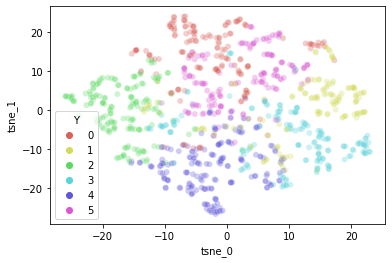

In [72]:
# plot proportions on unseen DATA
X_temp = X_full[idx_0,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_0,]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)



## TSNE unlabeled data  (30 degrees)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.837551
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.176079
[t-SNE] KL divergence after 300 iterations: 1.138423
t-SNE done! Time elapsed: 1.3128454685211182 seconds
(1000, 2)
(1000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

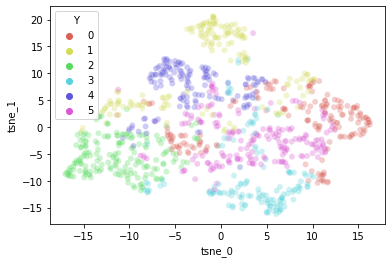

In [73]:
# plot proportions on unlabeled DATA
X_temp = X_full[idx_3,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_3,]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)



## TSNE All data (0-75)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.001s...
[t-SNE] Computed neighbors for 12000 samples in 4.893s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.635044
[t-SNE] KL divergenc

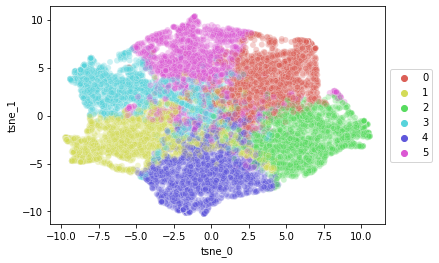

In [74]:
# plot proportions on ALL DATA
X_temp = X_full

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))



(12000, 2)
(12000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

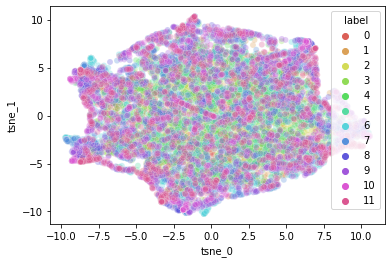

In [75]:
# plot rotations on digit embedding
# to see if rotation+digit are entangled
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.001s...
[t-SNE] Computed neighbors for 12000 samples in 4.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 1.299288
[t-SNE] KL divergenc

<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

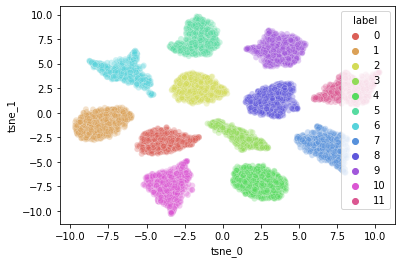

In [76]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)

(12000, 2)
(12000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

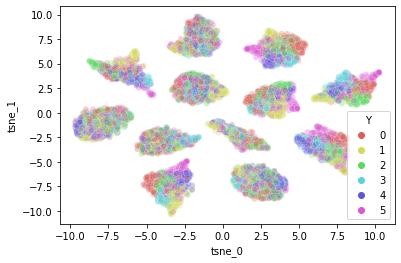

In [77]:
# plot digits on rotation embedding
# to see if rotation+digit are entangled

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)

## TSNE Training data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 3.500s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.665267
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.218964
[t-SNE] KL divergence after 300 iterations: 2.836534
t-SNE done! Time elapsed:

<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

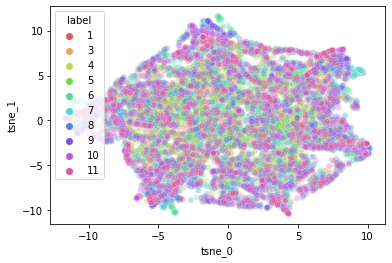

In [78]:
# plot proportion latent space of training data
X_temp = X_full[idx_train,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples-2),
    legend="full",
    alpha=0.3
)




(10000, 2)
(10000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

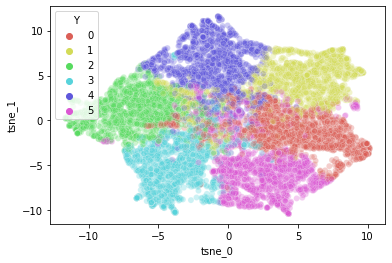

In [79]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)





/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 3.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.311396
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.526558
[t-SNE] KL divergence after 300 iterations: 2.721763
t-SNE done! Time elapsed:

<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

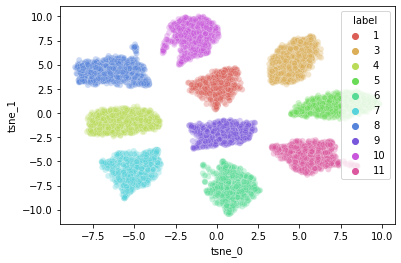

In [80]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples-2),
    legend="full",
    alpha=0.3
)


(10000, 2)
(10000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

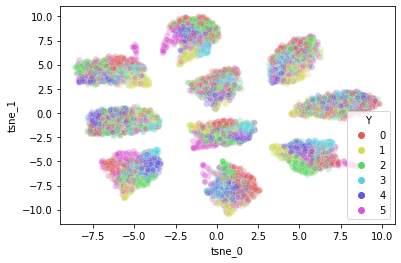

In [81]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 1.005s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.545814
[t-SNE] KL divergence after 50 iterations with early exaggeration: 94.444145
[t-SNE] KL divergence after 300 iterations: 2.971827
t-SNE done! Time elapsed: 

<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

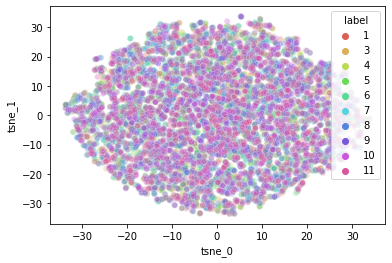

In [82]:
# plot remaining variance
z_test = z_slack
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples-2),
    legend="full",
    alpha=0.3
)


(10000, 2)
(10000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

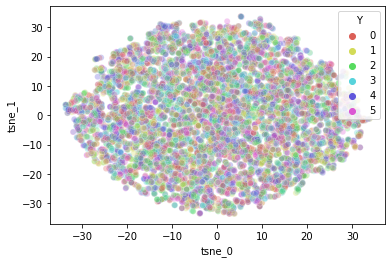

In [83]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)


# **Predict on our noise**

## Predict on unseen data

In [84]:
# test model on our invariant z_digit
Y_temp = Y_full[idx_0]
Y_digit = np.argmax(Y_temp, axis=1)
X_temp = X_full[idx_0,]
Label_temp = Label_full[idx_0,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = prop_outputs
encodings = np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)


test_error = [mean_sqr_error(Y_temp[idx], prop_outputs[idx]) 
                  for idx in range(0, X_temp.shape[1])]

print(f"MSE mean: {np.mean(test_error)}, max: {max(test_error)}")

test_error = [spearmanr(Y_temp[idx].astype(float), prop_outputs[idx].astype(float))[0]
                  for idx in range(0, X_temp.shape[1])]
print(f"Spearman mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")
test_error = [pearsonr(Y_temp[idx].astype(float), prop_outputs[idx].astype(float))[0]
                  for idx in range(0, X_temp.shape[1])]
print(f"Pearson mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

# write out the result
res = pd.DataFrame(encodings)
res.columns = Y_train.columns

res_file = os.path.join(res_data_path, f"train-{train_file_name}-test-{train_file_name}-DIVA.pkl")
res.to_pickle(res_file)



MSE mean: 0.002426209542702332, max: 0.01317069232033056
Spearman mean: 0.8064450613979718, median: 0.8285714285714287, max: 1.0
Pearson mean: 0.9249943185656107, median: 0.9531698935853057, max: 0.9997828108733783


In [85]:
print(Y_temp[0:3])
print(encodings[0:3])
np.sum(Y_temp[0:3], axis=1)
X_temp

[[0.038 0.0865 0.2345 0.0725 0.0295 0.539]
 [0.1885 0.0295 0.2635 0.2715 0.03 0.217]
 [0.156 0.294 0.051 0.3145 0.138 0.0465]]
[[0.06532331 0.09613237 0.25181898 0.11417434 0.07522544 0.39732558]
 [0.1281699  0.07773774 0.21924755 0.4130458  0.07263923 0.08915973]
 [0.09658861 0.2562229  0.08513995 0.2708491  0.21285668 0.07834282]]


array([[-0.25636018, -0.26546097, -0.25176997, ...,  2.73702032,
        -0.32108722, -0.32108722],
       [-0.26630181, -0.26145558, -0.26723099, ...,  2.613647  ,
        -0.31835534, -0.31835534],
       [-0.25985598, -0.22489918, -0.24013788, ...,  2.03424444,
        -0.27411165, -0.27411165],
       ...,
       [-0.25637999, -0.24748996, -0.25418406, ...,  2.49746095,
        -0.30550647, -0.30550647],
       [-0.26055376, -0.2330437 , -0.25107424, ...,  1.9072254 ,
        -0.29189753, -0.29189753],
       [-0.26485041, -0.22986764, -0.24644753, ...,  1.98594949,
        -0.28079313, -0.28079313]])

## Predict on New Sample

In [86]:
X_pbmc2, Y_pbmc2, pbmc2_gene_df = read_files(aug_data_path, 0, "pbmc_rep1_10xV2a")

# now we need to ensure the genes are in the same order
X_pbmc2.columns = pbmc2_gene_df["gene_ids"]
#X_pbmc2['ENSG00000135373_EHF'] = 0
#X_pbmc2['ENSG00000226622_AC092155.4'] = 0

#X_pbmc2['ENSG00000138755_CXCL9'] = 0
#X_pbmc2['ENSG00000197561_ELANE'] = 0

X_pbmc2 = X_pbmc2[gene_df["gene_ids"]]

# we also need to ensure that the cell-types are in the same order
Y_pbmc2 = Y_pbmc2[Y_train.columns]


X_pbmc2 = X_pbmc2.to_numpy()
Y_pbmc2 = Y_pbmc2.to_numpy()

# normalilze within sample
X_pbmc2 = scale(X_pbmc2, axis=1)
Y_pbmc2 = Y_pbmc2/Y_pbmc2.sum(axis=1,keepdims=1)


# now run it
z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_pbmc2, batch_size=batch_size)
z_test = prop_outputs
encodings = np.asarray(z_test)
encodings = encodings.reshape(X_pbmc2.shape[0], n_z)


test_error = [mean_sqr_error(Y_pbmc2[idx], encodings[idx]) 
                  for idx in range(0, X_pbmc2.shape[1])]

print(f"MSqE mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

test_error = [spearmanr(Y_pbmc2[idx].astype(float), encodings[idx].astype(float))[0]
                  for idx in range(0, X_pbmc2.shape[1])]
print(f"Spearman mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

test_error = [pearsonr(Y_pbmc2[idx].astype(float), encodings[idx].astype(float))[0]
                  for idx in range(0, X_pbmc2.shape[1])]
print(f"Pearson mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

# write out the result
res = pd.DataFrame(encodings)
res.columns = Y_train.columns

res_file = os.path.join(res_data_path, f"train-{train_file_name}-test-pbmc_rep1_10xV2a-DIVA.pkl")
res.to_pickle(res_file)



MSqE mean: 0.01792251790825361, median: 0.012336142488486884, max: 0.19460308384080663
Spearman mean: 0.4112008433147945, median: 0.48571428571428577, max: 1.0
Pearson mean: 0.4736993855523893, median: 0.6193248673358078, max: 0.9992791740013676


In [87]:
print(Y_pbmc2[0:3])
print(encodings[0:3])
np.sum(Y_pbmc2[0:3], axis=1)

[[0.13138686131386862 0.2400648824006488 0.038118410381184104
  0.05677210056772101 0.33982157339821567 0.1938361719383617]
 [0.055741360089186176 0.3935340022296544 0.10479375696767002
  0.03678929765886288 0.27759197324414714 0.13154960981047936]
 [0.2944630872483221 0.12583892617449663 0.322986577181208
  0.028523489932885903 0.05620805369127516 0.17197986577181204]]
[[0.13946284 0.12713617 0.0910954  0.33915794 0.11598321 0.18716447]
 [0.04293992 0.7858874  0.02924898 0.05400779 0.02867789 0.05923799]
 [0.1743318  0.41421682 0.15211259 0.13874829 0.03438546 0.08620504]]


array([0.9999999999999999, 1.0, 0.9999999999999998], dtype=object)

## Predict on New Tech

In [88]:
X_pbmc2, Y_pbmc2, pbmc2_gene_df = read_files(aug_data_path, 0, "pbmc_rep1_sm2")

# now we need to ensure the genes are in the same order
X_pbmc2.columns = pbmc2_gene_df["gene_ids"]
#X_pbmc2['ENSG00000135373_EHF'] = 0
#X_pbmc2['ENSG00000226622_AC092155.4'] = 0
#X_pbmc2['ENSG00000197353_LYPD2'] = 0
#X_pbmc2['ENSG00000269968_RP5-940J5.9'] = 0
#X_pbmc2['ENSG00000257764_RP11-1143G9.4'] = 0

X_pbmc2 = X_pbmc2[gene_df["gene_ids"]]

# we also need to ensure that the cell-types are in the same order
#Y_pbmc2['Natural killer cell'] = 0
#Y_pbmc2['Dendritic cell'] = 0
#Y_pbmc2['Plasmacytoid dendritic cell'] = 0
Y_pbmc2 = Y_pbmc2[Y_train.columns]


# now make it numpy arrays
X_pbmc2 = X_pbmc2.to_numpy()
Y_pbmc2 = Y_pbmc2.to_numpy()

# normalilze within sample
X_pbmc2 = scale(X_pbmc2, axis=1)


# now run it
z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_pbmc2, batch_size=batch_size)
z_test = prop_outputs
encodings = np.asarray(z_test)
encodings = encodings.reshape(X_pbmc2.shape[0], n_z)


test_error = [mean_sqr_error(Y_pbmc2[idx], encodings[idx]) 
                  for idx in range(0, X_pbmc2.shape[1])]

print(f"MSqE mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

test_error = [spearmanr(Y_pbmc2[idx].astype(float), encodings[idx].astype(float))[0]
                  for idx in range(0, X_pbmc2.shape[1])]
print(f"Spearman mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

test_error = [pearsonr(Y_pbmc2[idx].astype(float), encodings[idx].astype(float))[0]
                  for idx in range(0, X_pbmc2.shape[1])]
print(f"Pearson mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

# write out the result
res = pd.DataFrame(encodings)
res.columns = Y_train.columns

res_file = os.path.join(res_data_path, f"train-{train_file_name}-test-pbmc_rep1_sm2-DIVA.pkl")
res.to_pickle(res_file)


MSqE mean: 0.0373765174627373, median: 0.032582454617119776, max: 0.1622920207523327
Spearman mean: 0.23014486270061615, median: 0.2571428571428572, max: 1.0
Pearson mean: 0.2867440039350737, median: 0.3202118208388667, max: 0.9995242079313381


In [89]:
print(Y_pbmc2[4:8])
print(encodings[4:8])
np.sum(Y_pbmc2[4:8], axis=1)
X_pbmc2

[[0.12 0.1 0.12 0.51 0.11 0.04]
 [0.22 0.04 0.1 0.13 0.175 0.335]
 [0.05 0.025 0.1 0.24 0.275 0.31]
 [0.025 0.72 0.075 0.12 0.02 0.04]]
[[5.94013929e-03 9.14132744e-02 4.40977998e-02 4.91454363e-01
  2.56030122e-03 3.64534140e-01]
 [6.15027919e-02 9.43048894e-02 1.55120268e-01 1.85551912e-01
  3.84907126e-02 4.65029418e-01]
 [5.03843743e-03 7.56532177e-02 1.27948508e-01 1.23093516e-01
  3.24602425e-02 6.35806084e-01]
 [3.31246480e-03 8.20980906e-01 1.41439810e-02 3.36818323e-02
  8.14161322e-04 1.27066672e-01]]


array([[-0.32322774, -0.28467173, -0.18431642, ...,  5.60163585,
        -0.37064925, -0.37395259],
       [-0.30303001, -0.26024804, -0.20894251, ...,  4.61210381,
        -0.36573569, -0.36717084],
       [-0.31327658, -0.29053557, -0.25286948, ...,  5.11636944,
        -0.37629299, -0.37685201],
       ...,
       [-0.31231909, -0.27060582, -0.26583722, ...,  5.75647753,
        -0.3861594 , -0.38463661],
       [-0.30424121, -0.23562296, -0.29494292, ...,  5.47202782,
        -0.37215952, -0.37209505],
       [-0.27750952, -0.29572115, -0.18670747, ...,  4.83000963,
        -0.35920256, -0.36423431]])

# Predict on "Raw" data

## Predict on unseen data

In [90]:
# test model on our invariant z_digit
X_pbmc2, Y_pbmc2, pbmc2_gene_df = read_files(aug_data_path, 9999, "pbmc_rep2_10xV2")

# now we need to ensure the genes are in the same order
X_pbmc2.columns = pbmc2_gene_df["gene_ids"]

X_pbmc2 = X_pbmc2[gene_df["gene_ids"]]

# we also need to ensure that the cell-types are in the same order
Y_pbmc2 = Y_pbmc2[Y_train.columns]

X_pbmc2 = X_pbmc2.to_numpy()
Y_pbmc2 = Y_pbmc2.to_numpy()

# normalilze within sample
X_pbmc2 = scale(X_pbmc2, axis=1)

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_pbmc2, batch_size=batch_size)
z_test = prop_outputs
encodings = np.asarray(z_test)
encodings = encodings.reshape(X_pbmc2.shape[0], n_z)


test_error = [mean_sqr_error(Y_pbmc2[idx], prop_outputs[idx]) 
                  for idx in range(0, X_pbmc2.shape[1])]

print(f"MSE mean: {np.mean(test_error)}, max: {max(test_error)}")

test_error = [spearmanr(Y_pbmc2[idx].astype(float), prop_outputs[idx].astype(float))[0]
                  for idx in range(0, X_pbmc2.shape[1])]
print(f"Spearman mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")
test_error = [pearsonr(Y_pbmc2[idx].astype(float), prop_outputs[idx].astype(float))[0]
                  for idx in range(0, X_pbmc2.shape[1])]
print(f"Pearson mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

# write out the result
res = pd.DataFrame(encodings)
res.columns = Y_train.columns

res_file = os.path.join(res_data_path, f"train-{train_file_name}-test-pbmc_rep2_10xV2_9999-DIVA.pkl")
res.to_pickle(res_file)



KeyError: "['ENSG00000277399_GPR179', 'ENSG00000224194_AC008278.3', 'ENSG00000196600_SLC22A25', 'ENSG00000249346_LINC01016', 'ENSG00000231102_RP11-298J23.5', 'ENSG00000223351_ZNF385D-AS2', 'ENSG00000188916_FAM196A', 'ENSG00000228369_TXNDC12-AS1', 'ENSG00000275936_RP1-278C19.8', 'ENSG00000188818_ZDHHC11', 'ENSG00000251611_RP11-610P16.1', 'ENSG00000251675_CTC-458I2.2', 'ENSG00000172995_ARPP21', 'ENSG00000132746_ALDH3B2', 'ENSG00000253515_RP11-417F21.2', 'ENSG00000253807_LINC01170', 'ENSG00000253842_KB-173C10.1', 'ENSG00000231435_AC011747.3', 'ENSG00000144962_SPATA16', 'ENSG00000253901_RP11-122C21.1', 'ENSG00000254122_PCDHGB7', 'ENSG00000214102_WEE2', 'ENSG00000234409_CCDC188', 'ENSG00000234394_RP11-561O23.5', 'ENSG00000229972_IQCF3', 'ENSG00000256389_RP11-606D9.1', 'ENSG00000234203_RP5-1050D4.2', 'ENSG00000172461_FUT9', 'ENSG00000228741_SPATA13', 'ENSG00000134508_CABLES1', 'ENSG00000258225_RP11-136F16.1', 'ENSG00000234021_RP11-75C9.2', 'ENSG00000258573_RP11-14J7.6', 'ENSG00000259073_FOXN3-AS2', 'ENSG00000197748_CFAP43', 'ENSG00000259316_CTD-2116N17.1', 'ENSG00000232006_AC005537.2', 'ENSG00000101438_SLC32A1', 'ENSG00000260430_RP11-626G11.4', 'ENSG00000166148_AVPR1A', 'ENSG00000205037_RP11-863P13.4', 'ENSG00000235772_AP001625.6', 'ENSG00000260947_RP11-384P7.7', 'ENSG00000172318_B3GALT1', 'ENSG00000239480_RP11-514P8.2', 'ENSG00000280800_CH507-513H4.6', 'ENSG00000272043_RP11-44N11.3', 'ENSG00000166220_TBATA', 'ENSG00000140481_CCDC33', 'ENSG00000238160_AC116366.5', 'ENSG00000261618_RP11-79H23.3', 'ENSG00000263812_LINC00908', 'ENSG00000204022_LIPJ', 'ENSG00000226798_RP11-289F5.1', 'ENSG00000226806_AC011893.3', 'ENSG00000125798_FOXA2', 'ENSG00000116774_OLFML3', 'ENSG00000203730_TEDDM1', 'ENSG00000236951_AC007359.6', 'ENSG00000088367_EPB41L1', 'ENSG00000269881_AC004754.3', 'ENSG00000163554_SPTA1', 'ENSG00000267625_RP11-1094M14.14', 'ENSG00000236256_DIAPH2-AS1', 'ENSG00000188282_RUFY4', 'ENSG00000268104_SLC6A14', 'ENSG00000137507_LRRC32'] not in index"

## Predict on New Sample

In [ ]:
X_pbmc2, Y_pbmc2, pbmc2_gene_df = read_files(aug_data_path, 9999, "pbmc_rep1_10xV2a")

# now we need to ensure the genes are in the same order
X_pbmc2.columns = pbmc2_gene_df["gene_ids"]
X_pbmc2['ENSG00000135373_EHF'] = 0
X_pbmc2['ENSG00000226622_AC092155.4'] = 0

#X_pbmc2['ENSG00000138755_CXCL9'] = 0
#X_pbmc2['ENSG00000197561_ELANE'] = 0

X_pbmc2 = X_pbmc2[gene_df["gene_ids"]]

# we also need to ensure that the cell-types are in the same order
Y_pbmc2 = Y_pbmc2[Y_train.columns]

X_pbmc2 = X_pbmc2.to_numpy()
Y_pbmc2 = Y_pbmc2.to_numpy()

# normalilze within sample
X_pbmc2 = scale(X_pbmc2, axis=1)


# now run it
z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_pbmc2, batch_size=batch_size)
z_test = prop_outputs
encodings = np.asarray(z_test)
encodings = encodings.reshape(X_pbmc2.shape[0], n_z)


test_error = [mean_sqr_error(Y_pbmc2[idx], encodings[idx]) 
                  for idx in range(0, X_pbmc2.shape[1])]

print(f"MSqE mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

test_error = [spearmanr(Y_pbmc2[idx].astype(float), encodings[idx].astype(float))[0]
                  for idx in range(0, X_pbmc2.shape[1])]
print(f"Spearman mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

test_error = [pearsonr(Y_pbmc2[idx].astype(float), encodings[idx].astype(float))[0]
                  for idx in range(0, X_pbmc2.shape[1])]
print(f"Pearson mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

# write out the result
res = pd.DataFrame(encodings)
res.columns = Y_train.columns

res_file = os.path.join(res_data_path, f"train-{train_file_name}-test-pbmc_rep1_10xV2a_9999-DIVA.pkl")
res.to_pickle(res_file)



MSqE mean: 0.004423164071305386, median: 0.00402259331106279, max: 0.014833017007504981
Spearman mean: 0.6906333333333334, median: 0.7, max: 0.9833333333333333
Pearson mean: 0.8041516013269625, median: 0.8353835895759869, max: 0.9852995583563509


## Predict on New Tech

In [ ]:
X_pbmc2, Y_pbmc2, pbmc2_gene_df = read_files(aug_data_path, 9999, "pbmc_rep1_sm2")

# now we need to ensure the genes are in the same order
X_pbmc2.columns = pbmc2_gene_df["gene_ids"]
X_pbmc2['ENSG00000135373_EHF'] = 0
X_pbmc2['ENSG00000226622_AC092155.4'] = 0
X_pbmc2['ENSG00000197353_LYPD2'] = 0
X_pbmc2['ENSG00000269968_RP5-940J5.9'] = 0
X_pbmc2['ENSG00000257764_RP11-1143G9.4'] = 0

X_pbmc2 = X_pbmc2[gene_df["gene_ids"]]

# we also need to ensure that the cell-types are in the same order
Y_pbmc2['Natural killer cell'] = 0
Y_pbmc2['Dendritic cell'] = 0
Y_pbmc2['Plasmacytoid dendritic cell'] = 0
Y_pbmc2 = Y_pbmc2[Y_train.columns]


# now make it numpy arrays
X_pbmc2 = X_pbmc2.to_numpy()
Y_pbmc2 = Y_pbmc2.to_numpy()

# normalilze within sample
X_pbmc2 = scale(X_pbmc2, axis=1)


# now run it
z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_pbmc2, batch_size=batch_size)
z_test = prop_outputs
encodings = np.asarray(z_test)
encodings = encodings.reshape(X_pbmc2.shape[0], n_z)


test_error = [mean_sqr_error(Y_pbmc2[idx], prop_outputs[idx]) 
                  for idx in range(0, X_pbmc2.shape[1])]

print(f"MSE mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")
print(f"log10 mean test error: {log10(np.mean(test_error))}")

test_error = [spearmanr(Y_pbmc2[idx].astype(float), prop_outputs[idx].astype(float))[0]
                  for idx in range(0, X_pbmc2.shape[1])]
print(f"SPEARMAN mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")


test_error = [pearsonr(Y_pbmc2[idx].astype(float), prop_outputs[idx].astype(float))[0]
                  for idx in range(0, X_pbmc2.shape[1])]
print(f"Pearson mean: {np.mean(test_error)}, median: {np.median(test_error)}, max: {max(test_error)}")

# write out the result
res = pd.DataFrame(encodings)
res.columns = Y_train.columns

res_file = os.path.join(res_data_path, f"train-{train_file_name}-test-pbmc_rep1_sm2_9999-DIVA.pkl")
res.to_pickle(res_file)


MSE mean: 0.02407803395229108, median: 0.02284817126257819, max: 0.06454024080385157
log10 mean test error: -1.6183789774860449
SPEARMAN mean: 0.11798304963002101, median: 0.11866111313364182, max: 0.5254992153061281
Pearson mean: 0.2809121988544425, median: 0.28054550324217753, max: 0.835312592286406
